<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Reconocimiento facial con K-medias y K-medoides

En este caso-taller vamos a aplicar K-medias y K-medoides para agrupar rostros de indiviudos. Utilizaremos la base de datos conocida como Caras Olivetti. Esta base contiene diez imágenes diferentes de  40 personas distintas. Para algunas personas, las imágenes se tomaron en diferentes momentos, variando la iluminación, las expresiones faciales (ojos abiertos/cerrados, sonriendo/sin sonreír) y los detalles faciales (gafas/sin gafas). Todas las imágenes fueron tomadas contra un fondo homogéneo oscuro con los sujetos en una posición frontal erguida (con tolerancia a algún movimiento lateral). Esta base viene incluida dentro de la libraría `scikit-learn` y fueron provistas por T&T Laboratories Cambridge para que la comunidad académica la utilice para la evaluación de modelos predictivos. 

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.datasets import make_blobs


from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score


### 1.Carga de datos 

Los datos pueden ser bajados directamente utilizando la librería `scikit-learn`,  la función que le permite hacer esto es `fetch_olivetti_faces`. 

In [18]:
# Utilice este espacio para escribir el código.
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces(data_home='./data/')
X=data.data
y=data.target


Se descarga la data usando la funcion cargada y se elige que se guarden en una carpeta llamda data

### 2.  Análisis preliminar 

#### 2.1. Describa los contenidos de la base de datos, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [16]:
# Utilice este espacio para escribir el código.
print(type(data))

print(data.keys())

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'images', 'target', 'DESCR'])


Se tiene datos en clase sklearn.utils._bunch.Bunch.

Como se puede ver es un diccionario con 'data', 'images', 'target',  'DESCR'

'data': Contiene los datos de las características del dataset en forma de un array de NumPy

'images': Contiene las imágenes en formato de array de NumPy.

'target':Contiene las etiquetas o clases objetivo para cada ejemplo en el dataset.

'DESCR':Contiene una descripción del dataset.


In [19]:
print(X.shape)

(400, 4096)


Indica que cada una de las 400 imagenes en el dataset ha sido aplanada en un vector unidimensional que describe los valores de los pixeles, esto se hace para poder ser usados por algoritmos de aprendizaje, sin embargo se puede convertir multiplicando ancho x altura

In [20]:
imagenes = data.images
print(imagenes.shape)

(400, 64, 64)


En este caso se ve que hay 0 imagenes, con altura de 64 pixeles x ancho de 64 pixeles

In [21]:
description = data['DESCR']
print(description)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

Esta descripcion de arriba explica que se tienen fotos tomadas entre abril 1992 y april 1994 en AT&T Laboratories Cambridge. Son 10 imagenes de 40 personas diferentes, tomadas de diferentes angulos, a diferentes horas del dia, con ojos cerrados o abiertos, con diferentes expresiones, con diferentes detalles en la cara (con gafas y sin gafas) frente a un fondo negro.

Se puede usar esta base de datos para aprendizaje no supervisado pues se busca clasificar las 10 fotos de las personas en una de las 40 personas posibles (integer entre 0 y 39)

#### 2.2. Genere una figura con una imágen de cada uno de los individuos

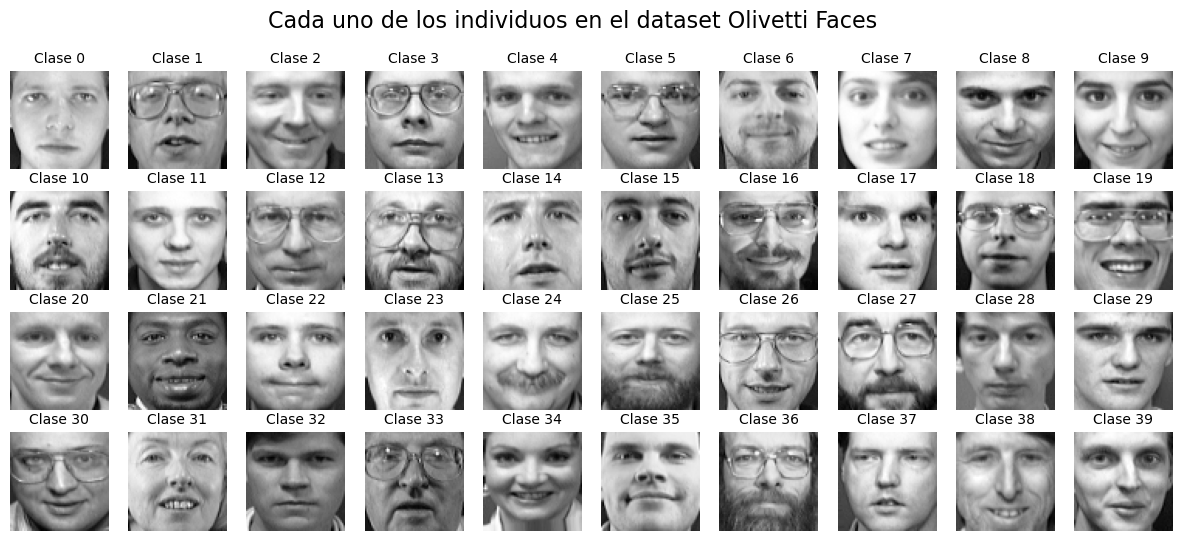

In [24]:
# Utilice este espacio para escribir el código.
unique_individuals = np.unique(y)

# Set up the figure
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle('Cada uno de los individuos en el dataset Olivetti Faces', fontsize=16)

# Plot one image of each individual
for i, individual in enumerate(unique_individuals):
    ax = axes[i // 10, i % 10]
    ax.imshow(X[y == individual][0].reshape(64, 64), cmap='gray')
    ax.set_title(f'Clase {individual}', fontsize=10)
    ax.axis('off')

plt.show()



Se puede ver entonces que es posible ver la cara de las personas y la case a la que pertenecen o su "target"

#### 2.3. Transforme las imágenes en un data frame donde cada columna contiene los valores estandarizados del nivel de gris en la imagen y una columna con la etiqueta de cada imagen. 

In [31]:
# Utilice este espacio para escribir el código.
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)

X_standardized = (X - mean_X) / std_X

df = pd.DataFrame(X_standardized, columns=[f'pixel_{i}' for i in range(X.shape[1])])

df['target'] = y

df = df.reindex(columns=['target'] + [f'pixel_{i}' for i in range(X.shape[1])])

df.head()

,target,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,-0.499904,-0.351181,-0.302961,-0.395362,-0.137608,0.104955,0.213296,0.194893,0.171394,...,1.834412,1.663788,1.598077,1.621725,0.726427,-1.092090,-0.959563,-0.898276,-0.831521,-0.850457
1,0,0.301499,0.194640,0.185687,0.203913,0.213404,0.290405,0.361848,0.355026,0.311534,...,-1.376154,-1.157251,-1.249631,-1.096955,-1.007795,-0.982782,-0.938375,-0.898276,-0.876586,-0.873362
2,0,-0.454109,-0.176518,0.079459,0.054094,0.169528,0.383130,0.361848,0.248271,0.255478,...,-1.752392,-1.293753,-0.999032,-1.162730,-1.141197,-1.004644,-0.980750,-0.964354,-0.899119,-0.873362
3,0,-1.118129,-1.268160,-1.450220,-1.679523,-1.936545,-2.236354,-2.262576,-1.566563,-1.230018,...,1.759165,1.481785,1.620859,1.753274,2.082678,2.143409,2.197308,2.295495,2.390681,2.379126
4,0,0.553368,0.587632,0.546861,0.546356,0.498602,0.568580,0.436124,0.435092,0.395619,...,-1.050081,-1.134501,-1.021814,-0.965406,-0.874393,-0.851614,-0.811253,-0.766120,-0.763922,-0.758838


De esta forma fue posible estandarizar los datos restandoles la media y dividiendo en la desviacion estandar cada pixel, de esta manera fue estandarizado el nivel de gris en las imagenes y se puede ver a continuacion como quedan:

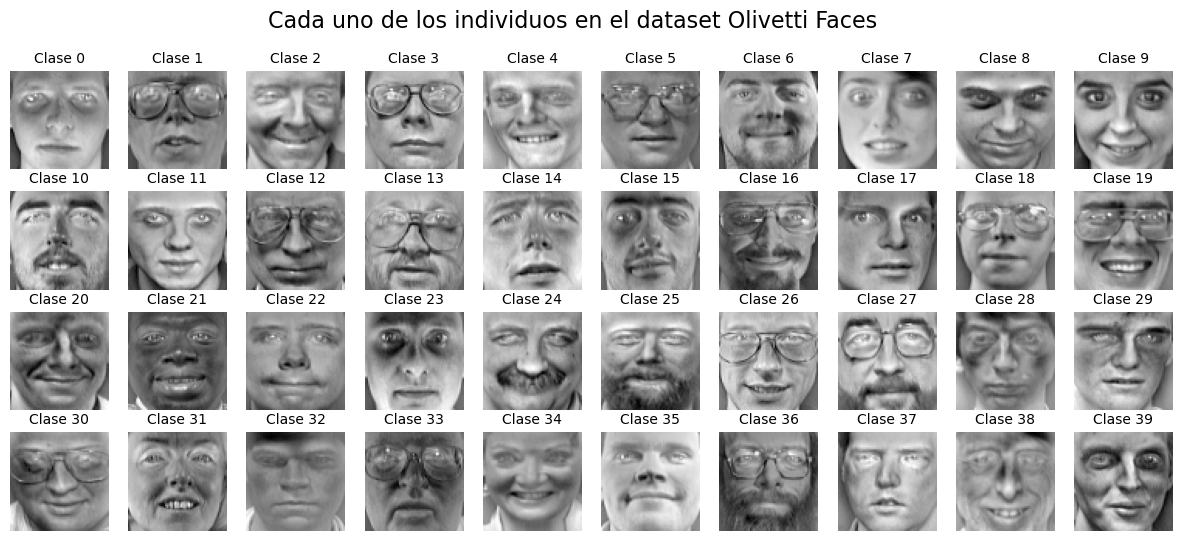

In [30]:
unique_individuals = np.unique(y)

# Set up the figure
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle('Cada uno de los individuos en el dataset Olivetti Faces', fontsize=16)

# Plot one image of each individual
for i, individual in enumerate(unique_individuals):
    ax = axes[i // 10, i % 10]
    ax.imshow(X_standardized[y == individual][0].reshape(64, 64), cmap='gray')
    ax.set_title(f'Clase {individual}', fontsize=10)
    ax.axis('off')

plt.show()


### 3. Clasificando de forma no supervisada

En esta sección trataremos de clasificar las imágenes de los individuos de forma no supervisada. Para ello utilizaremos los algoritmos de k-medias y k-medoides. Dado que sabemos que el dataset consta de 40 personas diferentes, utilizaremos esta información para pedirle a los algoritmos que encuentren k=40 clusters y examinaremos su precisión.


#### 3.1. Implemente k-medias sobre los datos estandarizados en el punto anterior. Al implementar utilice  `random_state=123` y `n_init=10`. (Esto puede tomar mucho tiempo y requerir mucho RAM, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [48]:
# Utilice este espacio para escribir el código.

kmeans =KMeans(n_clusters = 40, random_state = 123, n_init=10)

labels=kmeans.fit_predict(X_standardized)

centers = kmeans.cluster_centers_

c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [49]:
# Mostrar algunos resultados
print("Etiquetas de los primeros 10 ejemplos:", labels[:10])
print("Centros de los clusters (primeras 10 características):")
print(centers[:, :10])

Etiquetas de los primeros 10 ejemplos: [ 7 14  7  5 14  5  7 10 10 14]
Centros de los clusters (primeras 10 características):
[[-4.31212187e-01 -7.15061665e-01 -1.23422408e+00 -1.62244904e+00
  -1.89266813e+00 -2.07794905e+00 -2.03562093e+00 -1.71335149e+00
  -1.49628651e+00 -1.24583280e+00]
 [-3.73969108e-01 -1.43768862e-01  4.64003175e-01  1.13707030e+00
   1.38710082e+00  1.39151573e+00  1.29525197e+00  1.22507846e+00
   1.13836741e+00  1.06228077e+00]
 [-3.01461250e-01 -4.49948519e-01 -5.30591905e-01 -3.82112533e-01
  -1.94020316e-01 -4.40678261e-02  5.79429185e-03  1.82391964e-02
   2.32442021e-02  6.26509823e-03]
 [ 1.18321054e-01  4.83602285e-02 -8.83810222e-02 -1.25688031e-01
  -2.45105132e-01 -4.11987901e-01 -4.72520590e-01 -5.07020593e-01
  -5.46129405e-01 -7.24273980e-01]
 [ 5.07573664e-01  5.22132993e-01  3.46355915e-01  2.48056278e-01
   1.91466108e-01  2.06372738e-01  2.39602104e-01  1.69872552e-01
   8.38051587e-02  1.48411533e-02]
 [-4.28922385e-01 -6.19724870e-01 -7.19

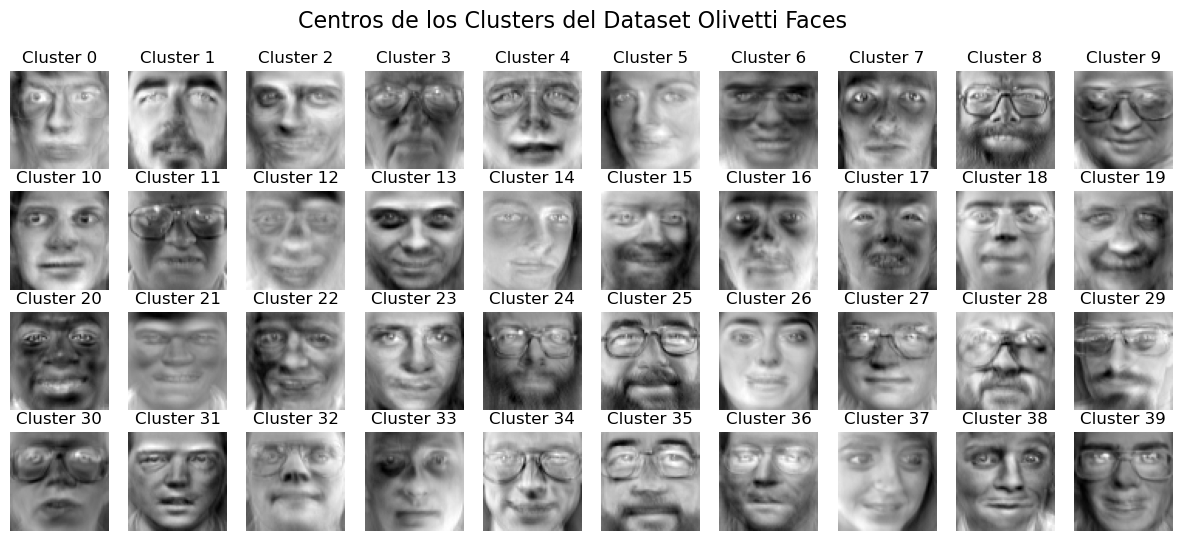

In [50]:
# Visualizar algunos centros de los clusters
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle('Centros de los Clusters del Dataset Olivetti Faces', fontsize=16)

for i in range(40):
    ax = axes[i // 10, i % 10]
    ax.imshow(centers[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Cluster {i}')
    ax.axis('off')

plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

#### 3.2. Evalúe la precisión del algoritmo para agrupar las imágenes de los individuos. 

In [25]:
# Utilice este espacio para escribir el código.


(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

#### 3.3. Usando PCA reduzca la dimensión de la matriz de predictores. Retenga el numero de componentes que explican el 95% de la varianza y vuelva a utilizar k-medias para clasificar las imágenes comentado si la precisión mejoró. 

In [26]:
# Utilice este espacio para escribir el código.


(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

#### 3.4. Utilice ahora el algoritmo por  K-medoides (use el mismo random state a los puntos anteriores), comente si mejoró la precisión total y para cada grupo de imágenes.

In [27]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

### 4. Número de clusters óptimo

En el punto anteriores utilizamos nuestro conocimiento previo sobre los datos para elegir el número de clusters. En este punto, verifique si 40 es realmente el número de cluster que usted elegiría según los criterios estudiados en los cuadernos teóricos. Discuta los resultados obtenidos.

In [28]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)